# Jupiter 2019 Test Case

In [1]:
# assuming that you're running this from the examples/ directory
# we need to add the path to the root folder into the system path so that we detect the fragmodel module
import sys
sys.path.append('../')
import numpy as np
from fragmentationmodel.fragmentation_model import FragmentationModel
from fragmentationmodel.planet import Planet
import matplotlib.pyplot as plt

## Setting the initial parameters
We need to first begin by setting the properties of the main body. Specifically these include:

- the mass

- entry velocity

- entry angle

- initial height

- ablation coeffient ($C_h$ or $\sigma_f$)

- initial strength ($\sigma$)

- strength power law coefficient (Weibull-relation $\alpha$)

- fragmentation efficiency ($C_{\text fr}$, see Sankar++2022)

- bulk density ($\rho_d$)

We also need to define the planetary properties and set the density profile ($\rho(z)$) for the atmosphere.

In [2]:
planet = Planet("Jupiter")
planet.define_temperature_profile('juptp/jupiter.tp')

In [3]:
''' initial parameters for the main body '''
kt = 4.184e12
E0 = 111.8*kt

v      = 60000.
theta  = 65.
h0     = 200000.
Ch     = 2.e-8
sigma  = 10.e3
alpha  = 0.0
Cfr    = 1.3
rho_d  = 500.
M      = 2.*E0/v**2.

''' initialize the model '''
fragmodel = FragmentationModel(M, v, theta, h0, sigma, Ch, rho_d, Cfr, alpha, planet)

[INFO]: fragmentationmodel.fragmentation_model -  Initializing with diameter: 9.975410639941622
[INFO]: fragmentationmodel.fragmentation_model -  planet: Jupiter g: 24.0 m/s^2; Rp: 70000.0 km


## Adding the child fragments
Once the main body is initialized, we can start adding the child fragments. These are defined by:

- mass

- ram pressure (or dynamic pressure) at which the fragment is released

- [optional] fragmentation efficiency ($C_{\text fr}$)

- [optional] initial strength ($\sigma$)

- [optional] new Weibull strength scaling power ($\alpha$)

In [4]:
fragmodel.add_fragment(0.02*M, 0.05e6, C_fr=3.,   alpha=0.0, initial_strength=0.06e6)
fragmodel.add_fragment(0.02*M, 0.06e6, C_fr=3.,   alpha=0.0, initial_strength=0.10e6)
fragmodel.add_fragment(0.02*M, 0.15e6, C_fr=2.0,  alpha=0.06)
fragmodel.add_fragment(0.03*M, 0.21e6, C_fr=2.0,  alpha=0.00)
fragmodel.add_fragment(0.04*M, 0.32e6, C_fr=3.,   alpha=0.02)
fragmodel.add_fragment(0.03*M, 0.28e6, C_fr=3.,   alpha=0.06)
fragmodel.add_fragment(0.06*M, 0.27e6, C_fr=1.2,  alpha=0.00, initial_strength=0.12e6)
fragmodel.add_fragment(0.22*M, 0.27e6, C_fr=1.8,  alpha=0.06, initial_strength=0.20e6)
fragmodel.add_fragment(0.06*M, 0.28e6, C_fr=1.8,  alpha=0.01, initial_strength=0.58e6)

## Running the model
Once the fragments are initialized, we can run the model forward in time. We also need to define the timestep and the stopping condition for each fragment (low velocity limit, low height limit). The output is a pandas `DataFrame` object with the state variables for each fragment (in the format `[fragment_id].[key]`, where `[fragment_id]` is either `main` or `f[number]` where number starts from 1 onwards), with one row per timestep. The `[key]` correspond to the following variables:

- mass

- velocity

- angle with respect to the horizontal

- height

- strength

- radius

- surface area

- mass_loss_rate

- acceleration

- dynamic_pressure

- fragment_mass

- fragment_count

- radiated (power)

- deposited (power)

- total (power)

For times before fragments have been released all of these values will be `NaN`s

In [5]:
df = fragmodel.integrate(dt=5e-4, max_time=40, min_velocity=1, min_height=-10000)

[INFO]: fragmentationmodel.fragment -  Releasing fragment 0 at time 0.00 s and height 200.00 km with mass 259.87 tonnes and velocity 60000.00 m/s
[INFO]: fragmentationmodel.fragment -  Releasing fragment 1 at time 0.04 s and height 197.88 km with mass 5.20 tonnes and velocity 60000.32 m/s
[INFO]: fragmentationmodel.fragment -  Releasing fragment 2 at time 0.12 s and height 193.56 km with mass 5.20 tonnes and velocity 60000.68 m/s
/home/kdavis/fragmodel_v5/examples/../fragmentationmodel/fragment.py:149: RuntimeWarning: invalid value encountered in sqrt
  self.state.radius = np.sqrt(S / (np.pi))
/home/kdavis/fragmodel_v5/examples/../fragmentationmodel/fragment.py:129: RuntimeWarning: invalid value encountered in scalar power
  dSdtfr = Cfr * np.sqrt(Pram - sigma) / (M**(1. / 3.) * self.bulk_density**(1. / 6.)) * S
[INFO]: fragmentationmodel.fragment -  Releasing fragment 3 at time 0.52 s and height 171.83 km with mass 5.20 tonnes and velocity 59987.60 m/s
[INFO]: fragmentationmodel.fragm

## Analyzing model results
Let's extract the energy deposition and ablative mass loss and plot those out

In [6]:
# get the observed energy deposition profile
lcdata = np.loadtxt('lightcurves/lightcurve_hueso.csv', delimiter=',', skiprows=1)

### Energy deposition

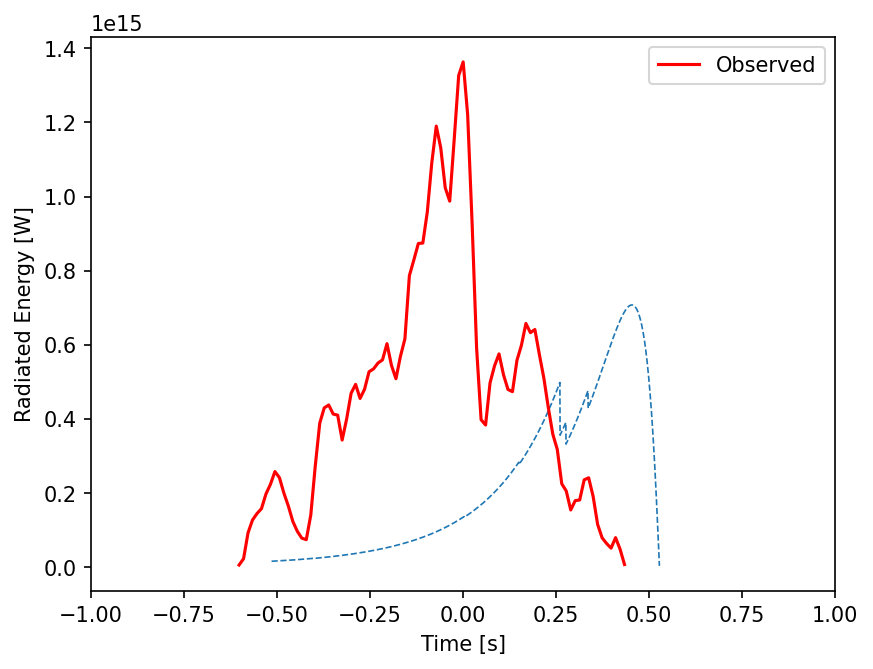

In [16]:
fig, ax = plt.subplots(1, 1, dpi=150)

# get the observed energy deposition profile
lctime = lcdata[:,1]
lcenergy = lcdata[:,3]/1.5

#1 kt in joules
filter_tau = (4.85e12)/E0

dEtdt_main = np.asarray(df['main.total'], copy=True)
dEtdt_f1 = np.asarray(df['f1.total'], copy=True)
dEtdt_f2 = np.asarray(df['f2.total'], copy=True)
dEtdt_f3 = np.asarray(df['f3.total'], copy=True)
dEtdt_f4 = np.asarray(df['f4.total'], copy=True)
dEtdt_f5 = np.asarray(df['f5.total'], copy=True)
dEtdt_f6 = np.asarray(df['f6.total'], copy=True)
dEtdt_f7 = np.asarray(df['f7.total'], copy=True)
dEtdt_f8 = np.asarray(df['f8.total'], copy=True)
dEtdt_f9 = np.asarray(df['f9.total'], copy=True)
dEtdt = dEtdt_main + dEtdt_f1 + dEtdt_f2 + dEtdt_f3 + dEtdt_f4 + dEtdt_f5 + dEtdt_f6 + dEtdt_f7 + dEtdt_f8 + dEtdt_f9
time = np.asarray(df['main.time'], copy=True)
dtoff = time[dEtdt.argmax()]
time -= dtoff

#ax.plot(time, dEtdt, 'k-', label='Modeled')

# plot the individual energy deposition curves
ax.plot(time, df['main.total'], '--', linewidth=0.8)
#ax.plot(time, dEtdt_f1, '--', linewidth=0.8)
#ax.plot(time, dEtdt_f2, '--', linewidth=0.8)
#ax.plot(time, dEtdt_f3, '--', linewidth=0.8)
#ax.plot(time, dEtdt_f4, '--', linewidth=0.8)
#ax.plot(time, dEtdt_f5, '--', linewidth=0.8)
#ax.plot(time, dEtdt_f6, '--', linewidth=0.8)
#ax.plot(time, dEtdt_f7, '--', linewidth=0.8)
#ax.plot(time, dEtdt_f8, '--', linewidth=0.8)
#ax.plot(time, dEtdt_f9, '--', linewidth=0.8)


# plot the observed data
ax.plot(lctime, lcenergy/filter_tau, 'r-', label='Observed')
#ax.set_xlim((-0.616, 0.4))
ax.set_xlim((-1,1))
ax.set_xlabel(r'Time [s]')
ax.set_ylabel(r'Radiated Energy [W]')
ax.legend(loc='best')

### Ablative mass loss fraction
To calculate the mass lost by ablation, we need to first remove the mass lost due to fragmentation from the main body, and then calculate the fraction of mass remaining over time

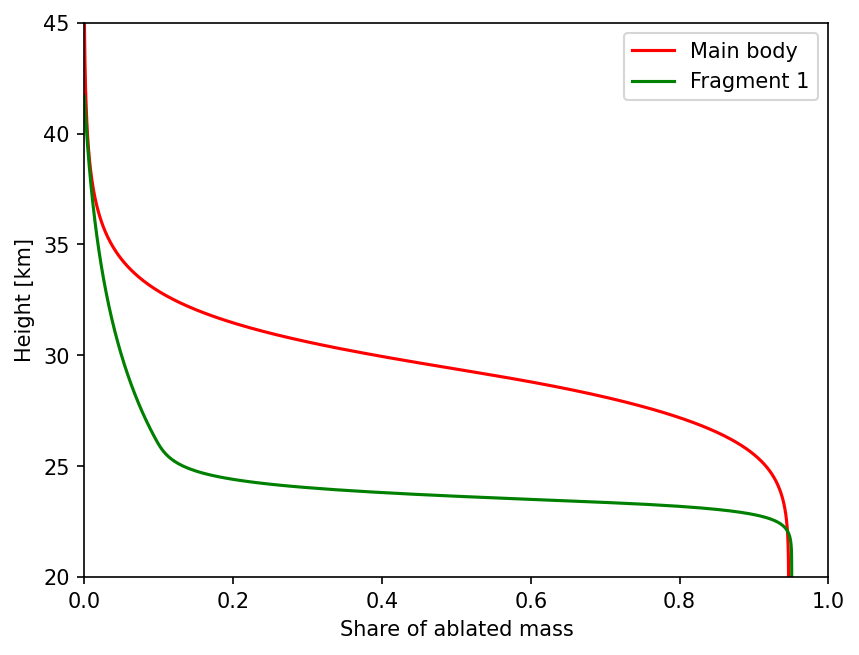

In [8]:
''' second plot is the fraction of mass that is ablated '''
fig, ax = plt.subplots(1, 1, dpi=150)

## construct the ablated mass profile
mfrag1 = np.array(df['f1.mass']).copy()
mfrag1[np.isfinite(mfrag1)] = fragmodel.fragments[0].initial_mass
mfrag1[np.isnan(mfrag1)] = 0
mmain = fragmodel.main_body.initial_mass - mfrag1
mainablation = 1. - df['main.mass'] / mmain

ax.plot(mainablation, df['main.height'] / 1e3, 'r-', label='Main body')
ax.plot(1 - df['f1.mass'] / fragmodel.fragments[0].initial_mass, df['f1.height'] / 1e3, 'g-', label='Fragment 1')

ax.set_ylim((20., 45.))
ax.set_xlim((0., 1.))
ax.set_xlabel(r'Share of ablated mass')
ax.set_ylabel(r'Height [km]')
ax.legend(loc='upper right')

plt.show()

## Saving the model configuration

We can save the model configuration by calling the `FragmentationModel.save_config()` method, which stores the configuration in a JSON file

In [10]:
fragmodel.save_config('J19_Comet.json')

In [12]:
import pprint
import json

# open the JSON and look at it's structure
with open('J19_Comet.json', 'r') as infile:
    config = json.load(infile)

pprint.pprint(config)

{'fragments': [{'C_fr': 3.0,
                'ablation_coefficient': 2e-08,
                'alpha': 0.0,
                'bulk_density': 500.0,
                'initial_mass': 5197.457777777778,
                'initial_strength': 60000.0,
                'release_pressure': 50000.0},
               {'C_fr': 3.0,
                'ablation_coefficient': 2e-08,
                'alpha': 0.0,
                'bulk_density': 500.0,
                'initial_mass': 5197.457777777778,
                'initial_strength': 100000.0,
                'release_pressure': 60000.0},
               {'C_fr': 2.0,
                'ablation_coefficient': 2e-08,
                'alpha': 0.06,
                'bulk_density': 500.0,
                'initial_mass': 5197.457777777778,
                'initial_strength': 10000.0,
                'release_pressure': 150000.0},
               {'C_fr': 2.0,
                'ablation_coefficient': 2e-08,
                'alpha': 0.0,
                'bulk_density'